## Detected AR Proababilities
**Author: Deanna Nash**

This notebook calculates the 2-3 week detected AR probabilities based on the Figure on the [CW3E Subseaasonal to Seasonal Forecasts](https://cw3e.ucsd.edu/s2s_forecasts/).

In [56]:
%matplotlib inline
import xarray as xr
import glob
import copy
import numpy as np
from datetime import datetime
import os
import sys
import pandas as pd

# plotting modules
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing
from IPython.display import Image, display
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import cmocean
import cmocean.cm as cmo

# other modules
import copy
import fsspec
# import xskillscore as xs

## import personal modules
sys.path.append('../modules') # Path to modules
from plotter import draw_basemap

In [2]:
# Set up paths

path_to_data = '/glade/scratch/acsubram/S2S_Database/'                            # project data -- read only
path_to_out  = '/glade/work/dlnash/asp2021/USWest_Water/output/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/glade/work/dlnash/asp2021/USWest_Water/figs/'      # figures

In [3]:
# parameters to set

# lat/lon bounds
latwant=[66,24] # North-to-South
lonwant=[180,240] # degrees East ... But what does that mean on a globe really? 

# plot bounds
lonmin= lonwant[0]
lonmax=lonwant[1]
latmin=latwant[1]
latmax=latwant[0]

### select initialization date
## we are interested in 2 week lead and 3 week lead
initial_dt = '2017-01-19 0:00' # 3-week lead for AR event 2

# subset to AR dates
AR_dates = ['2017-01-28 0:00', '2017-02-11 0:00'] # AR events first two
# set start and end dates
start_date = AR_dates[0]
end_date = AR_dates[1]

In [13]:
## load forecast!
fname='/glade/scratch/dlnash/data/arcatalog/out_ECMWF_hindcast_S2S_20170119.nc'
# fname='/glade/scratch/dlnash/data/arcatalog/out_ECMWF_hindcast_S2S_20151229.nc'
ds = xr.open_dataset(fname)

times_lst = pd.date_range(start='2017-01-19', end='2017-03-06', freq='1D')
# reassign valid_dates as lev
ds = ds.assign(lev=lambda ds: times_lst)
ds

## load observation!
fname='/glade/scratch/dlnash/data/arcatalog/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
obs = xr.open_dataset(fname)
obs = obs.squeeze()
# remove lev and ens coords
obs = obs.reset_coords(names=['lev', 'ens'], drop=True)

# subset to AR dates
tmp_for = ds.shape.sel(lev=slice(start_date, end_date))
tmp_obs = obs.shape.sel(time=slice(start_date, end_date))
tmp_obs = tmp_obs.resample(time='1D').count()

In [14]:
tmp_for

<xarray.DataArray 'shape' (ens: 50, time: 1, lev: 15, lat: 121, lon: 240)>
[21780000 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lev      (lev) datetime64[ns] 2017-01-28 2017-01-29 ... 2017-02-11
  * time     (time) datetime64[ns] 2017-01-19
  * ens      (ens) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 46.0 47.0 48.0 49.0 50.0
Attributes:
    long_name:  Shape
    units:      none

In [15]:
tmp_obs

<xarray.DataArray 'shape' (time: 15, lat: 121, lon: 240)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [2, 2, 2, ..., 2, 2, 2],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-01-28 2017-01-29 ... 2017-02-11
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 -90.0 -88.5 -87.0 -85.5 -84.0 ... 85.5 87.0 88.5 90.0

## Calculate detected AR Probabiities

In [17]:
# for each grid cell calculate the probability
# that an AR was detected by the Guan and Waliser AR Detection algorithm
# for each ensemble member, if shape > 0, then count 
# total count / nensembles
nens = len(tmp_for.ens)
# count the number of ensembles that detected an AR
IVT_ct = tmp_for.where(tmp_for > 0).count(dim='ens')

IVT_prob = (IVT_ct/nens)*100.
IVT_prob

<xarray.DataArray 'shape' (time: 1, lev: 15, lat: 121, lon: 240)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[2., 2., 2., ..., 2., 2., 2.],
         [0., 0., 0., ..., 0., 0., 0.],
         [2., 2., 2., ..., 0., 2., 2.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [2., 2., 2., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lev      (lev) datetime64[ns] 2017-01-28 2017-01-29 ... 2017-02-11
  * time     (time) datetime64[ns] 2017-01-19

## Make plots!

In [40]:
# plot bounds
lonmin= lonwant[0]
lonmax=lonwant[1]
latmin=latwant[1]
latmax=latwant[0]

# Data for plotting 
lons = tmp_for.lon.values
lats = tmp_for.lat.values

# Set up projection
mapcrs = ccrs.PlateCarree(central_longitude=180.0, globe=None)
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
# dx = np.arange(lonmin,lonmax+10,10)
# dy = np.arange(latmin,latmax+10,10)
dx = [180, -170, -150, -130]
dy = np.arange(25,65+20,20)


# plot title
# date = pd.date_range(start='2017-01-19', end='2017-01-19', freq='1D')
ts = pd.to_datetime('2017-01-19') 
d = ts.strftime('%Y.%m.%d')
plt_title = 'ECMWF Forecast Initialized: {0}'.format(d,)
print(plt_title)
# subtitles
plt_lbl = []
plt_lbl2 = []
obs_lbl = []
nleads = len(tmp_for.lev)
ndays = np.arange(9, 24, 1)
for k in range(nleads):
    date2 = tmp_obs.time.isel(time=k).values
    ts2 = pd.to_datetime(str(date2)) 
    d2 = ts2.strftime('%Y.%m.%d')
    plt_lbl.append("Valid: {0}".format(d2,))
    obs_lbl.append("{0}".format(d2,))
#     # calculate number of lead days
#     x = date2 - date
#     days = x.astype('timedelta64[D]')
#     ndays = days / np.timedelta64(1, 'D')
#     print(ndays)
    
    plt_lbl2.append("{:1d}-day lead".format(int(ndays[k]),))

# other plot parameters
cmap = cmo.thermal_r
clipcmap = cmocean.tools.crop_by_percent(cmap, 30, which='max', N=None)
cb_lbl = 'Probability of AR occurrence (%)'
cflevs = np.arange(10, 110, 10)
ext = [lonmin,lonmax,latmin,latmax]

# hack for tick labels
share_left = [True, False, False]*5
share_bottom = [False]*12 + [True]*3

ECMWF Forecast Initialized: 2017.01.19


/glade/u/home/acsubram/.conda/envs/ASP_USWest/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


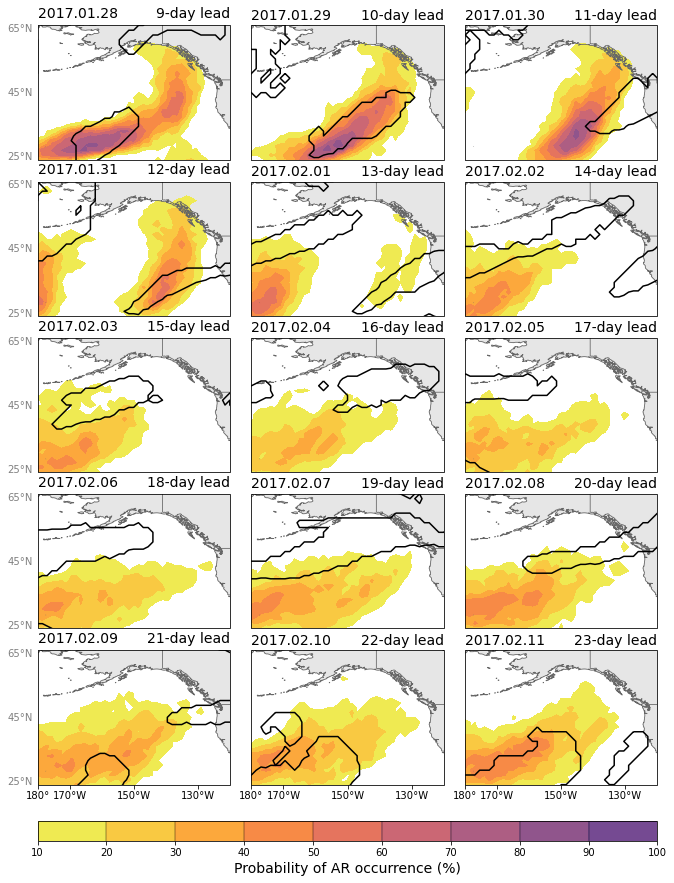

In [43]:
# Create AR probability figure
fig = plt.figure(figsize=(16,15))
# fname1 = path_to_figs + 'ens_2wk_probability_IVT_initialized_{0}.png'.format(d)
d='20170119'
fname1 = path_to_figs + 'ens_2wk_probability_IVT_initialized_{0}.png'.format(d)
nrows = 5
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.3,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.20, 
                cbar_size='5%',
                label_mode='',
                direction='row')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,
                      left_lats=share_left[k], right_lats=False, bottom_lons=share_bottom[k])
    ax.set_extent(ext, crs=datacrs)
    # hack for longitude labels
    if k >=12:
        ax.set_xticks(dx, crs=datacrs)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.xaxis.xlabel_style = {'size': 10, 'color': 'gray'}
        
    # Contour Filled
    data = IVT_prob.isel(lev=k).squeeze().values
    cf = ax.contourf(lons, lats, data, transform=datacrs,
                     levels=cflevs, cmap=clipcmap, extend='neither')
    
    # Plot observation
    obs_data = tmp_obs.isel(time=k).values
    clevs = [1]
    cs2 = ax.contour(lons, lats, obs_data, clevs, colors='k', linewidths=1.5,
                     linestyles='solid', transform=datacrs)

    # subtitles
    ax.set_title(obs_lbl[k], loc='left', fontsize=14)
    ax.set_title(plt_lbl2[k], loc='right', fontsize=14)

# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(cb_lbl, fontsize=14)
cb.ax.tick_params(labelsize=10)

# # set figure title
# # fig.suptitle(plt_title, fontsize=12)
# # Instead, do a hack by annotating the first axes with the desired 
# # string and set the positioning to 'figure fraction'.
# fig.get_axes()[0].annotate(plt_title, (0.5, 0.95), 
#                             xycoords='figure fraction', ha='center', 
#                             fontsize=12
#                             )

# Display figure
plt.savefig(fname1, dpi=300, bbox_inches='tight')

## Week 3 Probability compared to hindcast 

In [44]:
# load the ECMWF hindcast climatology
ecmwf_clim = xr.open_dataset('/glade/scratch/dlnash/data/arcatalog/AR_Freq_ECMWF.nc')
# select week-3 verification period
ecmwf_clim = ecmwf_clim.isel(time=2)
ecmwf_clim

<xarray.Dataset>
Dimensions:  (lat: 61, lon: 81)
Coordinates:
    time     timedelta64[ns] 21 days
  * lat      (lat) float32 10.0 11.0 12.0 13.0 14.0 ... 66.0 67.0 68.0 69.0 70.0
  * lon      (lon) float32 180.0 181.0 182.0 183.0 ... 257.0 258.0 259.0 260.0
Data variables:
    ar_freq  (lat, lon) float32 ...

In [47]:
### select initialization date
## we are interested in 2 week lead and 3 week lead
# initial_dt = '2017-01-16 0:00' # 2-week lead for AR event 1
# initial_dt = '2017-01-09 0:00' # 3-week lead for AR event 1

# initial_dt = '2017-01-23 0:00' # 2-week lead for AR event 2
initial_dt = '2017-01-19 0:00' # 3-week lead for AR event 2

### select AR event dates
# AR_dates = ['2017-01-29 0:00', '2017-02-03 0:00'] # AR event 1
AR_dates = ['2017-02-05 0:00', '2017-02-11 0:00'] # AR event 2


# set start and end dates
start_date = AR_dates[0]
end_date = AR_dates[1]

tmp_for = tmp_for.sel(lev=slice(start_date, end_date))
tmp_for = tmp_for.squeeze()
tmp_for

<xarray.DataArray 'shape' (ens: 50, lev: 7, lat: 121, lon: 240)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]],


       ...,


       [[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lev      (lev) datetime64[ns] 2017-02-05 2017-02-06 ... 2017-02-11
    time     datetime64[ns] 2017-01-19
  * ens      (ens) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 46.0 47.0 48.0 49.0 50.0
Attributes:
    long_name:  Shape
    units:      none

In [50]:
# for each grid cell calculate the probability
# that AR was detected
# for each ensemble member, if shape > 0, then count 
# average along ensemble dimension
nens = len(tmp_for.ens)
# count the number of ensembles that detected AR
IVT_ct = tmp_for.where(tmp_for > 0).count(dim='lev')

IVT_ct_mean = IVT_ct.mean(dim='ens')
IVT_ct_mean

<xarray.DataArray 'shape' (lat: 121, lon: 240)>
array([[0.08, 0.08, 0.08, ..., 0.08, 0.08, 0.08],
       [0.08, 0.08, 0.08, ..., 0.1 , 0.1 , 0.1 ],
       [0.18, 0.16, 0.16, ..., 0.14, 0.16, 0.16],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])
Coordinates:
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
    time     datetime64[ns] 2017-01-19

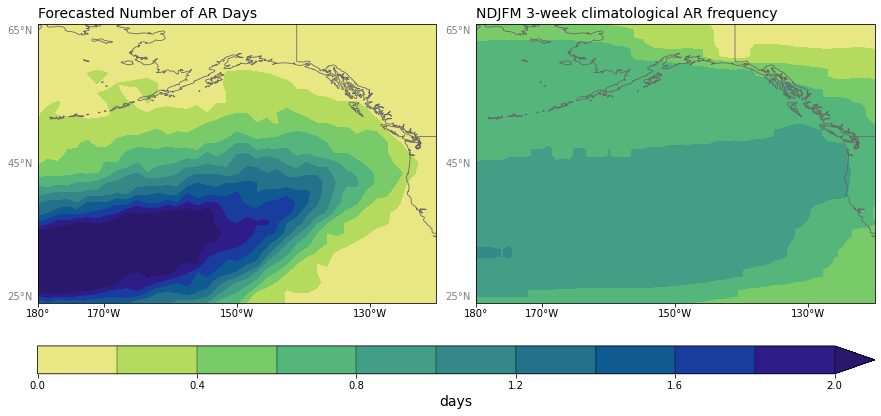

In [55]:
# other plot parameters
cmap = cmo.haline_r
clipcmap = cmocean.tools.crop_by_percent(cmap, 30, which='max', N=None)
cb_lbl = 'Probability of AR occurrence (%)'
# cflevs = [np.arange(0,2.2,0.2), np.arange(0., 1.6, 0.1)]
cflevs=np.arange(0., 2.2, 0.2)

# Data for plotting 
lons = [IVT_ct_mean.lon.values, ecmwf_clim.lon.values]
lats = [IVT_ct_mean.lat.values, ecmwf_clim.lat.values]
data = [IVT_ct_mean.values, ecmwf_clim.ar_freq.values]

plt_title = ['Forecasted Number of AR Days', 'NDJFM 3-week climatological AR frequency']
    
# Create figure
fig = plt.figure(figsize=(15,15))
fname2 = path_to_figs + 'week3_probability.png'
nrows = 1
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.05, 
                cbar_size='5%',
                label_mode='')


# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy)
    ax.set_extent(ext, crs=datacrs)
    # hack longitude labels
    ax.set_xticks(dx, crs=datacrs)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.xaxis.xlabel_style = {'size': 10, 'color': 'gray'}
    # Contour Filled
    cf = ax.contourf(lons[k], lats[k], data[k], transform=datacrs,
                     levels=cflevs, cmap=cmap, extend='max')

    # subtitles
    ax.set_title(plt_title[k], loc='left', fontsize=14)

    # single colorbar
    cb = fig.colorbar(cf, axgr.cbar_axes[k], orientation='horizontal', drawedges=True)
    cb.set_label('days', fontsize=14)
    cb.ax.tick_params(labelsize=10)

# Display figure
plt.savefig(fname2, dpi=300, bbox_inches='tight')